# Setup

In [1]:
# Import modules

import os, glob
import enum
import time
import random
import multiprocessing
from pathlib import Path

import torch
import torchvision
import torchio as tio
import torch.nn.functional as F

import numpy as np
from unet import UNet
from scipy import stats
import matplotlib.pyplot as plt

from IPython import display
from tqdm.notebook import tqdm

%config InlineBackend.figure_format = 'retina'
#num_workers = multiprocessing.cpu_count()
num_workers = 0
plt.rcParams['figure.figsize'] = 12, 6

print('Last run on', time.ctime())
print('TorchIO version:', tio.__version__)

Last run on Wed Jun  8 16:12:29 2022
TorchIO version: 0.18.76


In [2]:
compute_histograms = False
train_whole_images = False 
train_patches = False

EPOCHS = 10
NUM_CLASSES = 3

#histogram_landmarks_path = 'landmarks.npy'
DATA_DIR = '/media/trojan/evo/3D-CT-Artery-Segmentation/data_64_groups'

# Data

In [3]:
images_dir = os.path.join(DATA_DIR, 'train/images')
labels_dir = os.path.join(DATA_DIR, 'train/labels')
image_paths = sorted(glob.glob(images_dir + '/' + '*.nii.gz'))
label_paths = sorted(glob.glob(labels_dir + '/' + '*.nii.gz'))
assert len(image_paths) == len(label_paths)

training_subjects = []
for (image_path, label_path) in zip(image_paths, label_paths):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        label=tio.LabelMap(label_path),
    )
    training_subjects.append(subject)
training_dataset = tio.SubjectsDataset(training_subjects)
print('Dataset size:', len(training_dataset), 'training subjects')

Dataset size: 461 training subjects


In [4]:
validation_images_dir = os.path.join(DATA_DIR, 'val/images')
validation_labels_dir = os.path.join(DATA_DIR, 'val/labels')
validation_image_paths = sorted(glob.glob(validation_images_dir + '/' + '*.nii.gz'))
validation_label_paths = sorted(glob.glob(validation_labels_dir + '/' + '*.nii.gz'))
assert len(validation_image_paths) == len(validation_label_paths)

validation_subjects = []
for (image_path, label_path) in zip(validation_image_paths, validation_label_paths):
    subject = tio.Subject(
        image=tio.ScalarImage(image_path),
        label=tio.LabelMap(label_path),
    )
    validation_subjects.append(subject)
validation_dataset = tio.SubjectsDataset(validation_subjects)
print('Dataset size:', len(validation_dataset), 'validation subjects')

Dataset size: 121 validation subjects


# Training the network

## Prepare data

In [5]:
training_transform = tio.Compose([
    tio.ToCanonical(),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(num_classes=NUM_CLASSES),
])

validation_transform = tio.Compose([
    tio.ToCanonical(),
    tio.ZNormalization(masking_method=tio.ZNormalization.mean),
    tio.OneHot(num_classes=NUM_CLASSES),
])

num_training_subjects = len(training_dataset)
num_validation_subjects = len(validation_dataset)

torch.utils.data.DataLoader(training_dataset)
                            
training_set = tio.SubjectsDataset(
    training_subjects, transform=training_transform)

validation_set = tio.SubjectsDataset(
    validation_subjects, transform=validation_transform)

print('training set:', len(training_set), 'subjects')
print('validation set:', len(validation_set), 'subjects')

training set: 461 subjects
validation set: 121 subjects


## Deep learning stuff

In [6]:
device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [7]:
CHANNELS_DIMENSION = 1
SPATIAL_DIMENSIONS = 2, 3, 4
loss = torchvision.ops.sigmoid_focal_loss

In [14]:
class Action(enum.Enum):
    TRAIN = 'Training'
    VALIDATE = 'Validation'
    
def prepare_batch(batch, device):
    inputs = batch['image'][tio.DATA].to(device)
    targets = batch['label'][tio.DATA].to(device)
#     inputs = batch['image'][tio.DATA].type(torch.float32).to(device)
#     targets = batch['label'][tio.DATA].type(torch.float32).to(device)
    return inputs, targets

def get_model_and_optimizer(device):
    model = UNet(
        in_channels=1,
        out_classes=NUM_CLASSES,
        dimensions=3,
        num_encoding_blocks=3,
        out_channels_first_layer=8,
        normalization='batch',
        upsampling_type='linear',
        padding=True,
        activation='PReLU',
    ).to(device)
    optimizer = torch.optim.AdamW(model.parameters())
    return model, optimizer

def run_epoch(epoch_idx, action, loader, model, optimizer):
    is_training = action == Action.TRAIN
    epoch_losses = []
    times = []
    model.train(is_training)
    for batch_idx, batch in enumerate(tqdm(loader)):
        inputs, targets = prepare_batch(batch, device)
        optimizer.zero_grad()
        with torch.set_grad_enabled(is_training):
            logits = model(inputs)
            probabilities = F.sigmoid(logits)
            batch_losses = loss(probabilities.float(), targets.float())
            batch_loss = batch_losses.mean()
            if is_training:
                batch_loss.backward()
                optimizer.step()
            times.append(time.time())
            epoch_losses.append(batch_loss.item())
    epoch_losses = np.array(epoch_losses)
    print(f"{action.value} mean loss: {epoch_losses.mean():0.3f}")
    return times, epoch_losses

def train(num_epochs, training_loader, validation_loader, model, optimizer, weights_stem):
    train_losses = []
    val_losses = []
    val_losses.append(run_epoch(0, Action.VALIDATE, validation_loader, model, optimizer))
    for epoch_idx in range(1, num_epochs + 1):
        print('Starting epoch', epoch_idx)
        train_losses.append(run_epoch(epoch_idx, Action.TRAIN, training_loader, model, optimizer))
        val_losses.append(run_epoch(epoch_idx, Action.VALIDATE, validation_loader, model, optimizer))
        torch.save(model.state_dict(), f'./model/torchio/{weights_stem}_epoch_{epoch_idx}.pth')
    return np.array(train_losses), np.array(val_losses)

# Whole Images

In [15]:
training_batch_size = 1
validation_batch_size = training_batch_size

training_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=training_batch_size,
    shuffle=True,
)

validation_loader = torch.utils.data.DataLoader(
    validation_set,
    batch_size=validation_batch_size,
)

## Patch-based

Reference: https://torchio.readthedocs.io/_modules/torchio/data/queue.html

In [16]:
# train_patches = True

In [17]:
# training_batch_size = 1
# validation_batch_size = training_batch_size

# patch_size = 512,512,16
# samples_per_volume = 42  # 512/12
# max_queue_length = 210
# patch_overlap = 0,0,4
# sampler = tio.data.GridSampler(patch_size=patch_size, patch_overlap=patch_overlap)

# patches_training_set = tio.Queue(
#     subjects_dataset=training_set,
#     max_length=max_queue_length,
#     samples_per_volume=samples_per_volume,
#     sampler=sampler,
#     num_workers=num_workers,
#     shuffle_subjects=True,
#     shuffle_patches=True,
# )

# patches_validation_set = tio.Queue(
#     subjects_dataset=validation_set,
#     max_length=max_queue_length,
#     samples_per_volume=samples_per_volume,
#     sampler=sampler,
#     num_workers=num_workers,
#     shuffle_subjects=False,
#     shuffle_patches=False,
# )

# training_loader_patches = torch.utils.data.DataLoader(
#     patches_training_set, batch_size=training_batch_size)

# validation_loader_patches = torch.utils.data.DataLoader(
#     patches_validation_set, batch_size=validation_batch_size)

## Train

In [18]:
train_whole_images = True

  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.184
Starting epoch 1


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.120


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.092
Starting epoch 2


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.090


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089
Starting epoch 3


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.089


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089
Starting epoch 4


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.089


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089
Starting epoch 5


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.089


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089
Starting epoch 6


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.089


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089
Starting epoch 7


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.089


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089
Starting epoch 8


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.089


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089
Starting epoch 9


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.089


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089
Starting epoch 10


  0%|          | 0/461 [00:00<?, ?it/s]

Training mean loss: 0.089


  0%|          | 0/121 [00:00<?, ?it/s]

Validation mean loss: 0.089


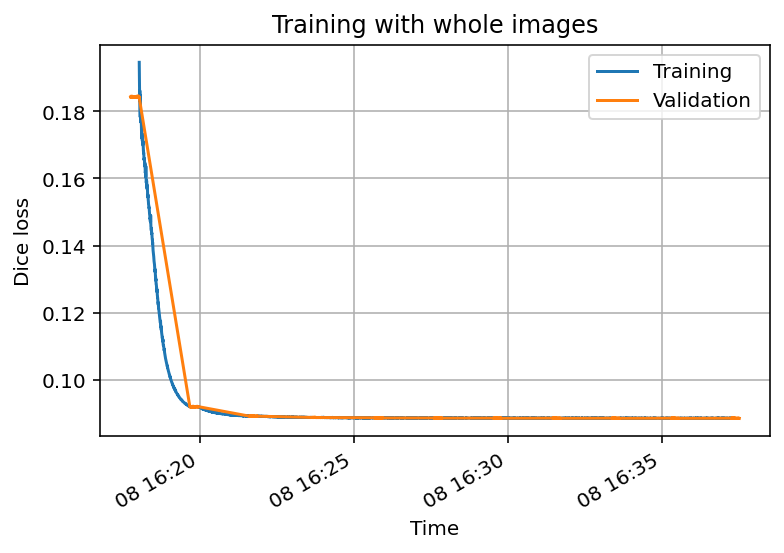

In [19]:
model, optimizer = get_model_and_optimizer(device)
weights_path = './model/torchio/whole_image_state_dict.pth'
if train_whole_images:
    weights_stem = 'whole_images'
    train_losses, val_losses = train(EPOCHS, training_loader, validation_loader, model, optimizer, weights_stem)
    checkpoint = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'weights': model.state_dict(),
    }
    torch.save(checkpoint, weights_path)
else:
    checkpoint = torch.load(weights_path)
    model.load_state_dict(checkpoint['weights'])
    train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

def plot_times(axis, losses, label):
    from datetime import datetime
    times, losses = losses.transpose(1, 0, 2)
    times = [datetime.fromtimestamp(x) for x in times.flatten()]
    axis.plot(times, losses.flatten(), label=label)
    
fig, ax = plt.subplots()
plot_times(ax, train_losses, 'Training')
plot_times(ax, val_losses, 'Validation')
ax.grid()
ax.set_xlabel('Time')
ax.set_ylabel('Dice loss')
ax.set_title('Training with whole images')
ax.legend()
fig.autofmt_xdate()

# Prediction

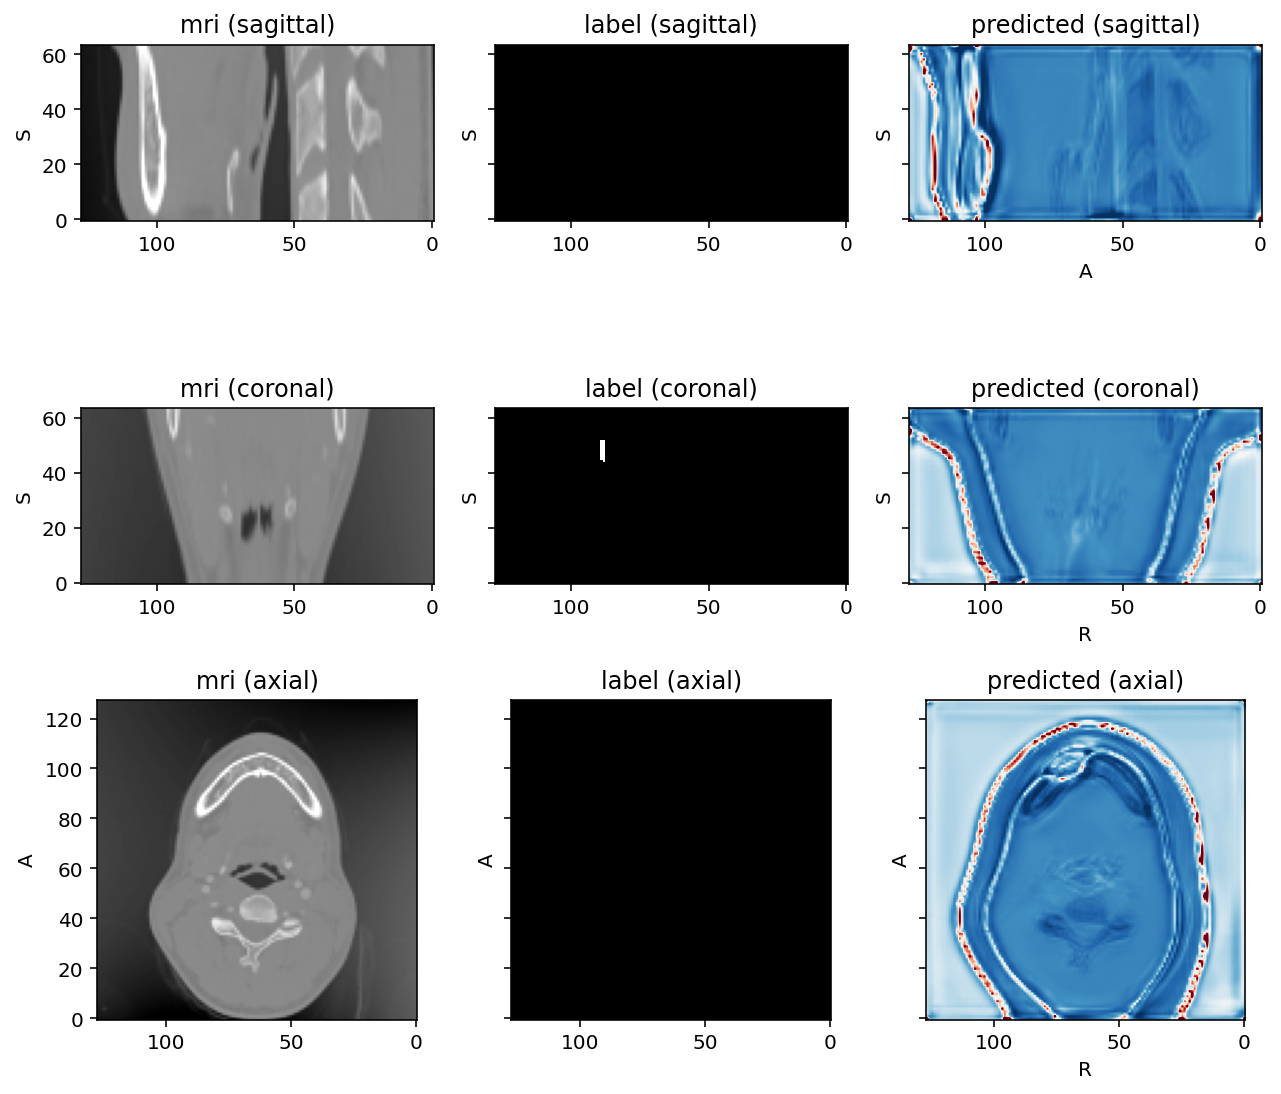

In [22]:
batch = next(iter(validation_loader))
model.eval()
inputs, targets = prepare_batch(batch, device)
FIRST = 0
FOREGROUND = 1
with torch.no_grad():
    probabilities = model(inputs).softmax(dim=1)[:, FOREGROUND:].cpu()
affine = batch['image'][tio.AFFINE][0].numpy()
subject = tio.Subject(
    mri=tio.ScalarImage(tensor=batch['image'][tio.DATA][FIRST], affine=affine),
    label=tio.LabelMap(tensor=batch['label'][tio.DATA][FIRST], affine=affine),
    predicted=tio.ScalarImage(tensor=probabilities[FIRST], affine=affine),
)
subject.plot(figsize=(9, 8), cmap_dict={'predicted': 'RdBu_r'})

In [ ]:
# model, optimizer = get_model_and_optimizer(device)
# weights_path = './model/weights_focal_loss/patches_state_dict.pth'

# if train_patches:
#     weights_stem = 'patches'
#     train_losses, val_losses = train(
#         EPOCHS,
#         training_loader_patches,
#         validation_loader_patches,
#         model,
#         optimizer,
#         weights_stem,
#     )
#     checkpoint = {
#         'train_losses': train_losses,
#         'val_losses': val_losses,
#         'weights': model.state_dict(),
#     }
#     torch.save(checkpoint, weights_path)
    
# else:
#     checkpoint = torch.load(weights_path)
#     model.load_state_dict(checkpoint['weights'])
#     train_losses, val_losses = checkpoint['train_losses'], checkpoint['val_losses']

In [ ]:
# def plot_times(axis, losses, label):
#     from datetime import datetime
#     times, losses = losses.transpose(1, 0, 2)
#     times = [datetime.fromtimestamp(x) for x in times.flatten()]
#     axis.plot(times, losses.flatten(), label=label)

    
# fig, ax = plt.subplots()
# plot_times(ax, train_losses, 'Training')
# plot_times(ax, val_losses, 'Validation')
# ax.grid()
# ax.set_xlabel('Time')
# ax.set_ylabel('Dice loss')
# ax.set_title('Training with patches (subvolumes)')
# ax.legend() 
# fig.autofmt_xdate()